In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.utils as utils
import seaborn as sns
from collections import Counter

from tqdm import tqdm
import src.dtw as dtw
from joblib import Parallel, delayed
import src.dba as dba
from sklearn.metrics import accuracy_score
from tslearn.barycenters import euclidean_barycenter
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
import pickle
import time

from src.kmedoid import KMedoid
from src.kmean import KMeans
from src.rdm import RDm
from src.agh import AGH

In [2]:
# Path of the train and test dataset
train_set_path = 'UCRArchive_2018/InsectWingbeatSound/InsectWingbeatSound_TRAIN.tsv'
test_set_path = 'UCRArchive_2018/InsectWingbeatSound/InsectWingbeatSound_TEST.tsv'

# Extract the time series and classes for train and test set
train_labels, train_ts = utils.extract_ts_from_file(train_set_path)
test_labels, test_ts = utils.extract_ts_from_file(test_set_path)

$$ \textbf{Analyse des données} $$

In [3]:
print(f"L'ensemble d'entrainement est composé de {train_ts.shape[0]} échantillons de longueur {train_ts.shape[1]}")
print(f"L'ensemble de test est composé de {test_ts.shape[0]} échantillons de longueur {test_ts.shape[1]}")

L'ensemble d'entrainement est composé de 220 échantillons de longueur 256
L'ensemble de test est composé de 1980 échantillons de longueur 256


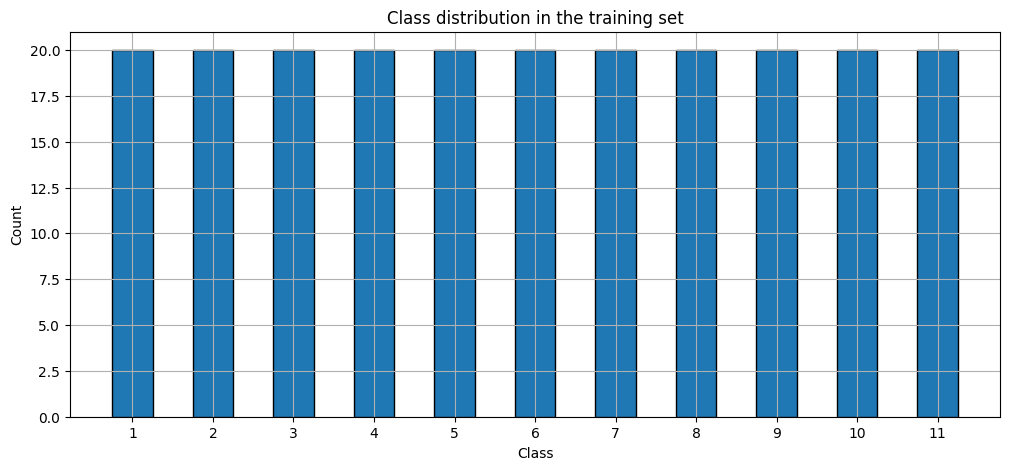

In [4]:
count = Counter(train_labels)

plt.figure(figsize = (12, 5))
plt.grid(True)
plt.bar(count.keys(), count.values(), width = 0.5, edgecolor = 'black')
plt.xlabel("Class")
plt.ylabel("Count")

plt.title("Class distribution in the training set")

plt.xticks([i for i in count.keys()])
plt.show()

In [5]:
EXEC = False
if EXEC :
    def compute_dtw(i, j):
        return i, j, dtw.get_dtw_distance(train_ts[i], train_ts[j])

    train_set_size = len(train_labels)

    DTW_distance_matrix = np.zeros([train_set_size, train_set_size])

    results = Parallel(n_jobs=-1)(delayed(compute_dtw)(i, j) 
                                for i in tqdm(range(train_set_size), disable = False) 
                                for j in range(i, train_set_size))

    # Remplissage de la matrice à partir des résultats
    for i, j, dist in results:
        DTW_distance_matrix[i, j] = dist
        DTW_distance_matrix[j, i] = dist
else : 
    DTW_distance_matrix = np.load('train_dtw_InsectWingbeatSound.npy')

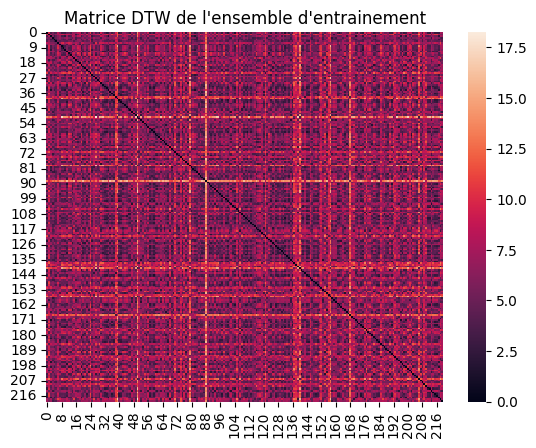

In [6]:
sns.heatmap(DTW_distance_matrix)
plt.title("Matrice DTW de l'ensemble d'entrainement")
plt.show()

In [7]:
# Récupération des différentes classes du dataset
class_ids = sorted(list(count.keys()))
nb_class = len(class_ids)

# Récupération des index associées aux différentes classes
## Comme chaque classe est composée de 20 échantillons
class_id_arr = np.zeros([nb_class, 20], dtype = int)
for _, class_id in enumerate(class_ids):
    class_id_arr[class_id - 1] = np.where(train_labels == class_id)[0]

# Récupération des séries temporelles de chacune des classes
class_ts = np.zeros([nb_class, 20, 256])
for i, class_id in enumerate(class_ids):
    selected_indices = class_id_arr[i, :20].astype(int)
    class_ts[i] = train_ts[selected_indices]


# Calcul de la "moyenne" de ces séries en utilisant la DBA et la distance euclidienne
class_dba = np.zeros([nb_class, 256])
class_euc = np.zeros([nb_class, 256])
for i in tqdm(range(nb_class)):
    class_dba[i] = dba.DBA(X = train_ts, 
                           D = class_ts[i], 
                           id_D = class_id_arr[i], 
                           nb_iter = 10, 
                           dtw_matrix = DTW_distance_matrix, 
                           subset_size = 20)
    
    class_euc[i] = np.squeeze(euclidean_barycenter(class_ts[i]))

100%|██████████| 11/11 [02:55<00:00, 15.93s/it]


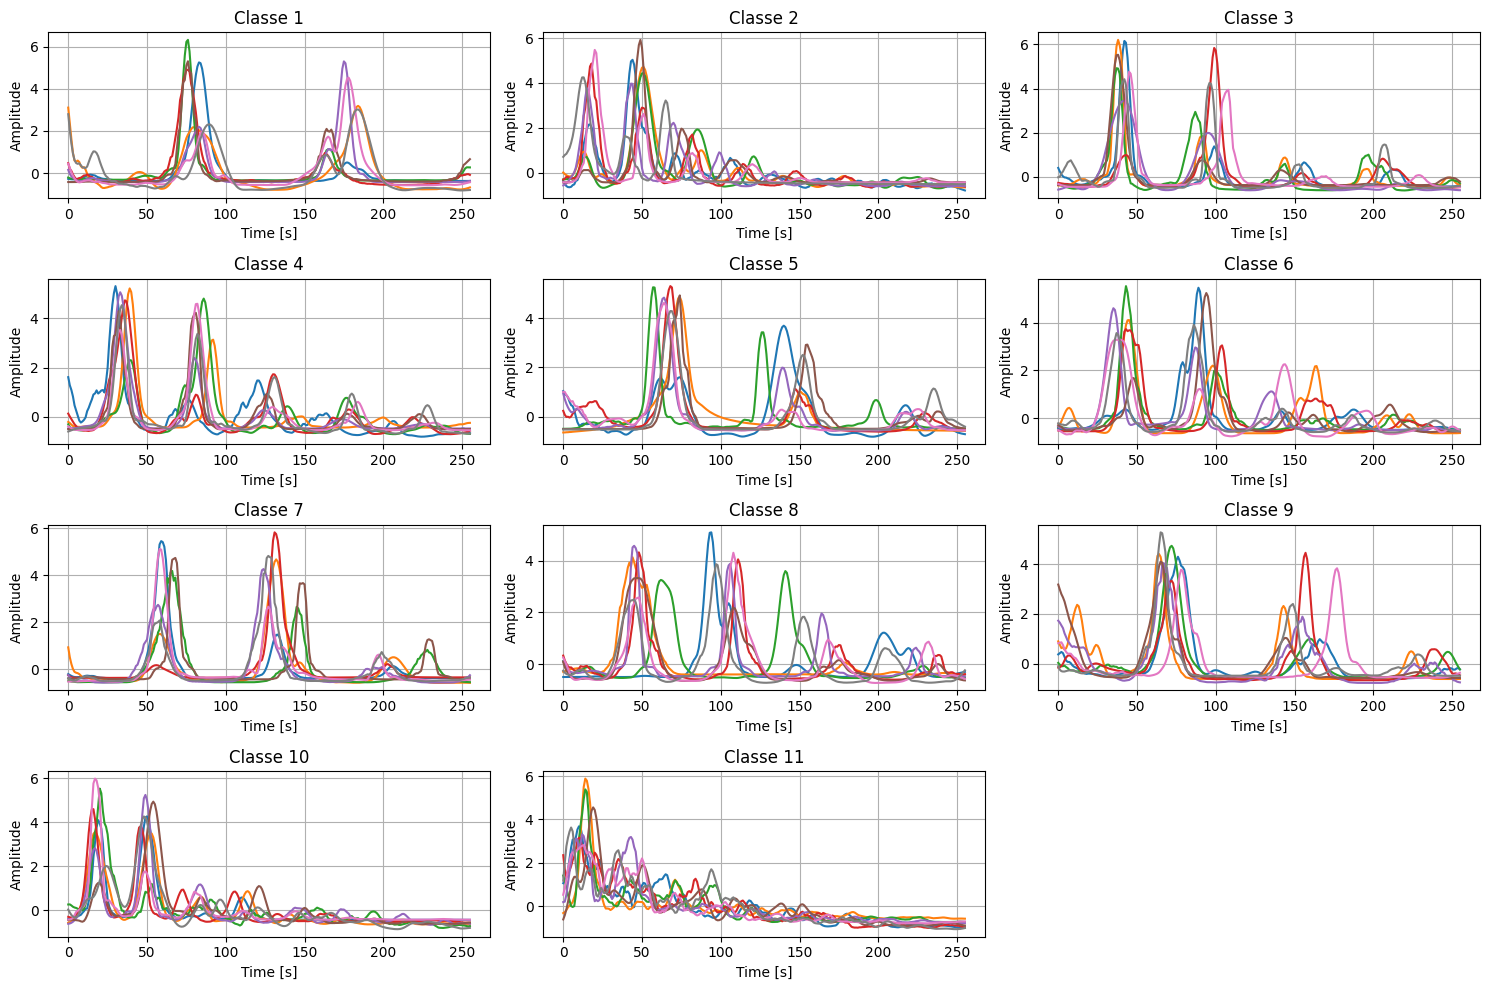

In [8]:
# Visualisons des échantillons de chacune des 11 classes
fig, axes = plt.subplots(4, 3, figsize=(15, 10)) 
axes = axes.flatten() 

for i in range(min(nb_class, 12)):
    for j in range(8): 
        axes[i].plot(class_ts[i, j], label=f"Échantillon {j+1}")
    axes[i].set_title(f"Classe {i+1}")
    axes[i].grid(True)
    axes[i].set_xlabel('Time [s]')
    axes[i].set_ylabel('Amplitude')

for k in range(nb_class, 12):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

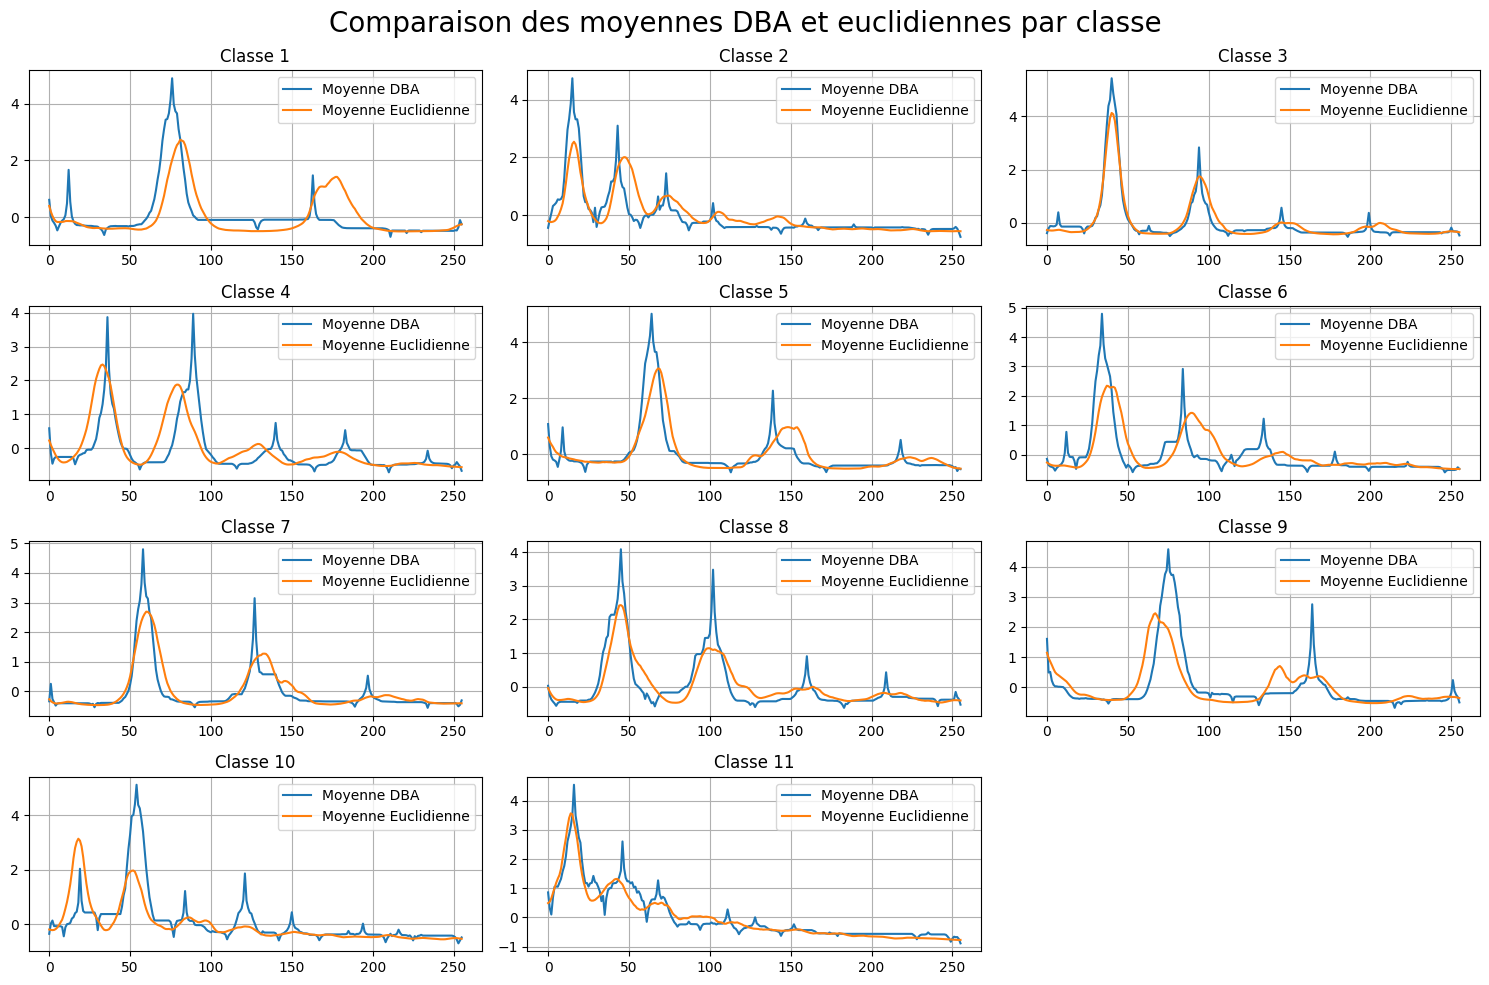

In [9]:
# Comparaison des moyennes euclidiennes et DBA
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(nb_class):
    axes[i].plot(class_dba[i], label='Moyenne DBA')
    axes[i].plot(class_euc[i], label='Moyenne Euclidienne')
    axes[i].set_title(f'Classe {i + 1}')
    axes[i].grid(True)
    axes[i].legend()
    axes[i].grid(True)

for j in range(nb_class, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Comparaison des moyennes DBA et euclidiennes par classe", fontsize = 20)
plt.tight_layout()
plt.show()


$$ \textbf{Evaluation des différentes méthodes} $$

### Condensation des données par K-Means

In [12]:
def get_KMeans_centroids(ts_set, classes_id, n_clusters):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing centroid for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        class_idx = np.where(train_labels == id_class)
        
        class_dtw_mat = dtw.extract_sub_dtw_mat(DTW_distance_matrix, list(class_idx[0]))
        KM_Classifier = KMeans(nb_clusters = n_clusters, max_iter = 20, eps = 0.1)
        KM_Classifier.fit(class_ts, class_dtw_mat)

        centroids[idx] = KM_Classifier.centroids

    return centroids

# Pour paralléliser
def compute_centroids_for_n_clusters(n_clusters, train_ts, classes_id):
    return n_clusters, get_KMeans_centroids(
        ts_set=train_ts,
        classes_id=classes_id,
        n_clusters=n_clusters
    )

In [17]:
# Récupération des différentes classes du dataset
classes_id = np.unique(train_labels)

# Récupération des centroides pour différentes valeurs de n_clusters
n_clusters = np.arange(1, 11)
results = Parallel(n_jobs=-1)(delayed(compute_centroids_for_n_clusters)(
    n_clusters, train_ts, classes_id
) for n_clusters in n_clusters)

# Stockage des différents centroides dans un dictionnaire
all_centroids = {n_clusters: centroids for n_clusters, centroids in results}

In [11]:
all_centroids = {}

with open("k_means_centroids.pkl", "rb") as file:
    all_centroids = pickle.load(file)

In [13]:
k_means_acc = []
k_means_time = []

for i in tqdm(range(1, 11)):
    # Reshape the centroid array
    reshaped_centroid = all_centroids[i].reshape(nb_class*i, -1)
    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * i)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw')   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    k_means_time.append(end_time - start_time)
    k_means_acc.append(accuracy_score(test_labels, predictions))

    print(f"Accuracy pour {i} clusters : {k_means_acc[-1]} | Complexité temporelle : {k_means_time[-1]}")

 10%|█         | 1/10 [00:10<01:32, 10.33s/it]

Accuracy pour 1 clusters : 0.2717171717171717 | Complexité temporelle : 10.324728012084961


 20%|██        | 2/10 [00:29<02:04, 15.58s/it]

Accuracy pour 2 clusters : 0.31565656565656564 | Complexité temporelle : 19.248356580734253


 30%|███       | 3/10 [00:51<02:08, 18.39s/it]

Accuracy pour 3 clusters : 0.32171717171717173 | Complexité temporelle : 21.722273588180542


 40%|████      | 4/10 [01:19<02:14, 22.39s/it]

Accuracy pour 4 clusters : 0.31767676767676767 | Complexité temporelle : 28.510293006896973


 50%|█████     | 5/10 [01:55<02:16, 27.28s/it]

Accuracy pour 5 clusters : 0.33080808080808083 | Complexité temporelle : 35.96010732650757


 60%|██████    | 6/10 [02:38<02:09, 32.44s/it]

Accuracy pour 6 clusters : 0.35808080808080806 | Complexité temporelle : 42.43436098098755


 70%|███████   | 7/10 [03:28<01:54, 38.16s/it]

Accuracy pour 7 clusters : 0.35404040404040404 | Complexité temporelle : 49.924352407455444


 80%|████████  | 8/10 [04:26<01:29, 44.60s/it]

Accuracy pour 8 clusters : 0.353030303030303 | Complexité temporelle : 58.39479446411133


 90%|█████████ | 9/10 [05:31<00:51, 51.00s/it]

Accuracy pour 9 clusters : 0.35 | Complexité temporelle : 65.061350107193


100%|██████████| 10/10 [06:45<00:00, 40.56s/it]

Accuracy pour 10 clusters : 0.3515151515151515 | Complexité temporelle : 73.97724533081055


### Condensation des données par Random selection

In [14]:
def get_Rdm_centroids(ts_set, classes_id, n_clusters):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing Random centroids for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        
        KM_Classifier = RDm(nb_clusters = n_clusters)
        KM_Classifier.fit(class_ts)

        centroids[idx] = KM_Classifier.centroids

    return centroids

In [16]:
classes_id = sorted(np.unique(labels))

In [17]:
rdm_acc = []
rdm_time = []

for n_clusters in range(1, 11) :
    rdm_centroids = get_Rdm_centroids(ts_set = train_ts, 
                                  classes_id = classes_id, 
                                  n_clusters = n_clusters)
    
    # Reshape the centroid array
    reshaped_centroid = rdm_centroids.reshape(nb_class * n_clusters, -1)

    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * n_clusters)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw')   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    rdm_acc.append(accuracy_score(test_labels, predictions))
    rdm_time.append(end_time - start_time)

    print(f"Accuracy pour {n_clusters} clusters : {rdm_acc[-1]} | Prediction time : {rdm_time[-1]}")
    

11it [00:00, 11016.56it/s]


Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11
Accuracy pour 1 clusters : 0.20505050505050504 | Prediction time : 8.318897724151611


11it [00:00, 7544.95it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 2 clusters : 0.2409090909090909 | Prediction time : 16.063976287841797


11it [00:00, 4921.84it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 3 clusters : 0.2631313131313131 | Prediction time : 30.60289740562439


11it [00:00, 5848.31it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 4 clusters : 0.3085858585858586 | Prediction time : 32.2563271522522


11it [00:00, 5029.69it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 5 clusters : 0.2924242424242424 | Prediction time : 45.76512598991394


11it [00:00, 2947.88it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 6 clusters : 0.29444444444444445 | Prediction time : 53.6137535572052


11it [00:00, 5505.65it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 7 clusters : 0.301010101010101 | Prediction time : 49.35991668701172


11it [00:00, 8235.87it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 8 clusters : 0.31313131313131315 | Prediction time : 64.85456109046936


11it [00:00, 4479.35it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 9 clusters : 0.31212121212121213 | Prediction time : 69.71257138252258


11it [00:00, 5242.88it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 10 clusters : 0.32727272727272727 | Prediction time : 79.74522423744202


### Condensation des données par K-Medoid

In [18]:
def get_KMedoid_centroids(ts_set, classes_id, n_clusters):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing centroid for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        class_idx = np.where(train_labels == id_class)
        
        class_dtw_mat = dtw.extract_sub_dtw_mat(DTW_distance_matrix, list(class_idx[0]))
        KMed_Classifier = KMedoid(nb_clusters = n_clusters, max_iter = 10, eps = 0.1)
        KMed_Classifier.fit(class_ts, class_dtw_mat)

        centroids[idx] = KMed_Classifier.centroids

    return centroids

In [19]:
kmed_acc = []
kmed_time = []

for n_clusters in tqdm(range(1, 11)):
    # Reshape the centroid array
    centroids = get_KMedoid_centroids(ts_set = train_ts, 
                                      classes_id = classes_id, 
                                      n_clusters = n_clusters)
    
    reshaped_centroid = centroids.reshape(nb_class*n_clusters, -1)
    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * n_clusters)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw')   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    kmed_acc.append(accuracy_score(test_labels, predictions))
    kmed_time.append(end_time - start_time)

    print(f"Accuracy pour {n_clusters} clusters : {kmed_acc[-1]} | Prediction time : {kmed_time[-1]}")


11it [00:00, 563.68it/s]0:00<?, ?it/s]


Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 

 10%|█         | 1/10 [00:08<01:17,  8.66s/it]

Accuracy pour 1 clusters : 0.23232323232323232 | Prediction time : 8.634669065475464


11it [00:00, 962.84it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 20%|██        | 2/10 [00:24<01:42, 12.78s/it]

Accuracy pour 2 clusters : 0.29393939393939394 | Prediction time : 15.641692876815796


11it [00:00, 804.95it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 30%|███       | 3/10 [00:47<02:03, 17.59s/it]

Accuracy pour 3 clusters : 0.29494949494949496 | Prediction time : 23.28628659248352


11it [00:00, 714.88it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 40%|████      | 4/10 [01:18<02:16, 22.72s/it]

Accuracy pour 4 clusters : 0.29444444444444445 | Prediction time : 30.54363751411438


11it [00:00, 673.82it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 50%|█████     | 5/10 [01:57<02:22, 28.60s/it]

Accuracy pour 5 clusters : 0.3429292929292929 | Prediction time : 38.994115352630615


11it [00:00, 696.41it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 60%|██████    | 6/10 [02:44<02:20, 35.00s/it]

Accuracy pour 6 clusters : 0.3101010101010101 | Prediction time : 47.41590738296509


11it [00:00, 498.29it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 70%|███████   | 7/10 [03:39<02:04, 41.53s/it]

Accuracy pour 7 clusters : 0.3409090909090909 | Prediction time : 54.92227864265442


11it [00:00, 567.33it/s]


Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 

 80%|████████  | 8/10 [04:46<01:39, 49.57s/it]

Accuracy pour 8 clusters : 0.3095959595959596 | Prediction time : 66.76810455322266


11it [00:00, 539.32it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 90%|█████████ | 9/10 [06:10<01:00, 60.26s/it]

Accuracy pour 9 clusters : 0.32323232323232326 | Prediction time : 83.71831250190735


11it [00:00, 535.02it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


100%|██████████| 10/10 [07:42<00:00, 46.25s/it]

Accuracy pour 10 clusters : 0.3287878787878788 | Prediction time : 92.27174186706543


### AGH

In [20]:
def get_AGH_centroids(ts_set, classes_id, n_clusters):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing centroid for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        class_idx = np.where(train_labels == id_class)
        
        class_dtw_mat = dtw.extract_sub_dtw_mat(DTW_distance_matrix, list(class_idx[0]))
        AGH_Classifier = AGH(nb_clusters = n_clusters, max_iter = 10, eps = 0.1)
        AGH_Classifier.fit(class_ts, class_dtw_mat)

        centroids[idx] = AGH_Classifier.centroids

    return centroids

In [21]:
agh_acc = []
agh_time = []

for n_clusters in tqdm(range(1, 11)):
    # Reshape the centroid array
    centroids = get_AGH_centroids(ts_set = train_ts, 
                                classes_id = classes_id, 
                                n_clusters = n_clusters)
    
    reshaped_centroid = centroids.reshape(nb_class*n_clusters, -1)
    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * n_clusters)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw')   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    agh_acc.append(accuracy_score(test_labels, predictions))
    agh_time.append(end_time - start_time)

    print(f"Accuracy pour {n_clusters} clusters : {agh_acc[-1]} | Prediction time : {agh_time[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [01:03,  5.76s/it]
 10%|█         | 1/10 [01:11<10:43, 71.55s/it]

Accuracy pour 1 clusters : 0.2383838383838384 | Prediction time : 8.150532484054565


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [01:12,  6.63s/it]
 20%|██        | 2/10 [02:43<11:06, 83.33s/it]

Accuracy pour 2 clusters : 0.22373737373737373 | Prediction time : 18.648380994796753


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [01:28,  8.04s/it]
 30%|███       | 3/10 [04:37<11:22, 97.51s/it]

Accuracy pour 3 clusters : 0.22121212121212122 | Prediction time : 25.926594495773315


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [01:39,  9.04s/it]
 40%|████      | 4/10 [06:46<10:58, 109.75s/it]

Accuracy pour 4 clusters : 0.23535353535353534 | Prediction time : 29.022987127304077


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [01:46,  9.67s/it]
 50%|█████     | 5/10 [09:10<10:11, 122.29s/it]

Accuracy pour 5 clusters : 0.25555555555555554 | Prediction time : 38.13563251495361


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [01:57, 10.70s/it]
 60%|██████    | 6/10 [11:52<09:03, 135.92s/it]

Accuracy pour 6 clusters : 0.2601010101010101 | Prediction time : 44.65805172920227


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [02:09, 11.82s/it]
 70%|███████   | 7/10 [14:52<07:30, 150.29s/it]

Accuracy pour 7 clusters : 0.27474747474747474 | Prediction time : 49.90474319458008


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [02:16, 12.44s/it]
 80%|████████  | 8/10 [18:05<05:27, 163.89s/it]

Accuracy pour 8 clusters : 0.2813131313131313 | Prediction time : 56.15834832191467


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [02:28, 13.54s/it]
 90%|█████████ | 9/10 [21:39<02:59, 179.36s/it]

Accuracy pour 9 clusters : 0.29343434343434344 | Prediction time : 64.38127160072327


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [02:22, 12.95s/it]
100%|██████████| 10/10 [25:09<00:00, 150.99s/it]

Accuracy pour 10 clusters : 0.2909090909090909 | Prediction time : 68.27813339233398


In [26]:
one_nn_clf = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = "dtw")

one_nn_clf.fit(train_ts, train_labels)

start_time = time.time()
predictions = one_nn_clf.predict(test_ts)
end_time = time.time()

print(f"1-NN DTW accuracy : {accuracy_score(test_labels, predictions)} | Prediction time : {end_time - start_time}")

1-NN DTW accuracy : 0.35505050505050506 | Prediction time : 162.0110740661621


In [28]:
one_nn_error_rate = 1 - accuracy_score(test_labels, predictions)

$$\textbf{Visualisation des résultats}$$

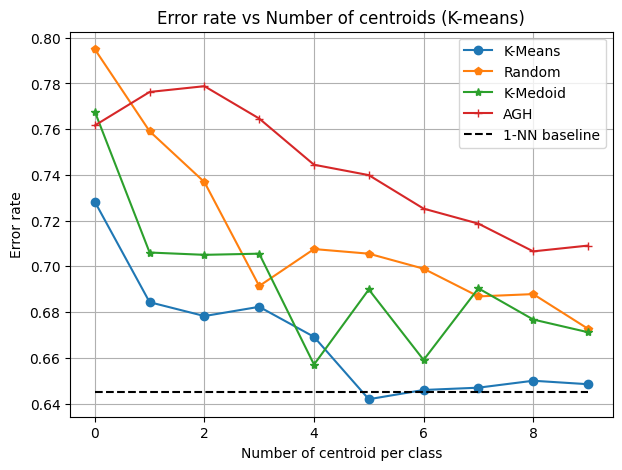

In [29]:
error_rate_km = np.ones([10]) - k_means_acc
error_rate_rdm = np.ones([10]) - rdm_acc
error_rate_k_med = np.ones([10]) - kmed_acc
error_rate_agh = np.ones([10]) - agh_acc

plt.figure(figsize = (7, 5))
plt.plot(error_rate_km, marker = 'o', label = "K-Means")
plt.plot(error_rate_rdm, marker = 'p', label = 'Random')
plt.plot(error_rate_k_med, marker ='*', label = 'K-Medoid')
plt.plot(error_rate_agh, marker = '+', label = 'AGH')
plt.plot(one_nn_error_rate*np.ones([10]), linestyle = '--', label = '1-NN baseline', color = 'black')
plt.xlabel('Number of centroid per class')
plt.ylabel('Error rate')
plt.grid(True)
plt.title('Error rate vs Number of centroids (K-means)')
plt.legend()
plt.show()

En conclusion, on obtient des résultats légèrement meilleurs en condensant l'ensemble d'entrainement avec un algorithme K-means où K = 5. En parallèle, le temps de calcul est diminué de manière drastique : 35 secondes contre 162 secondes, soit une amélioration de 78% !

En revanche, la méthode AHC obtient des résultats décevant et n'arrive pas à faire mieux que les méthodes de condesation par $\textbf{Random Selection}$ et $\textbf{K-Medoid}$.